In this competition, you’ll gain access to two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled train.csv and the other is titled test.csv.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

Check out the “Data” tab to explore the datasets even further. Once you feel you’ve created a competitive model, submit it to Kaggle to see where your model stands on our leaderboard against other Kagglers.

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# loading the data into pandas dataframes
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender = pd.read_csv('gender_submission.csv')
print(f'size of train dataframe = {train.shape}')

train_raw = train.copy()
test_raw = test.copy()


size of train dataframe = (891, 12)


In [126]:
# only step of data preparation necessary is fill missing age values with adequate values, based on the 'Sib Sp', 'Parch', and 'Fare' values. That indicate the most what could be the passenger's real age
grouped_age_train = train.groupby(['Parch', 'SibSp', 'Survived', 'Pclass', 'Sex'])['Age'].mean().reset_index()
# now it is possible to access the mean value of passengers of given Parch, SibSp and Fare status

print(f'Number of NaN before treatment = {train.Age.isna().sum()}')
# so I will create a functio to iterate through rows and fill missing values with the mean value in the groupby object
def fill_age(row):
    if pd.isna(row['Age']):
        matching_rows = grouped_age[
            (grouped_age['Parch'] == row['Parch']) &
            (grouped_age['SibSp'] == row['SibSp']) &
            (grouped_age['Survived'] == row['Survived']) &
            (grouped_age['Pclass'] == row['Pclass']) &
            (grouped_age['Sex'] == row['Sex'])
        ]
        if not matching_rows.empty:
            print(f'replaced age value {row["Age"]} for value {matching_rows["Age"].values[0]}')
            return matching_rows['Age'].values[0]
        else:
            return np.nan
    else:
        return row['Age']


for index, row in train.iterrows():
    train.loc[index, 'Age'] = fill_age(row)

print(f'Number of NaN after treatment = {train.Age.isna().sum()}')

# Dropping these rows won't have great effects on the final classification
train.dropna(subset=['Age'], inplace=True)
print(f'new size of train dataframe = {train.shape}')
train.Age = train.Age.astype(int)

Number of NaN before treatment = 177
replaced age value nan for value 29.338509316770185
replaced age value nan for value 37.6
replaced age value nan for value 22.38095238095238
replaced age value nan for value 29.338509316770185
replaced age value nan for value 22.38095238095238
replaced age value nan for value 29.338509316770185
replaced age value nan for value 37.43478260869565
replaced age value nan for value 22.38095238095238
replaced age value nan for value 28.23076923076923
replaced age value nan for value 29.338509316770185
replaced age value nan for value 29.338509316770185
replaced age value nan for value 26.071428571428573
replaced age value nan for value 22.38095238095238
replaced age value nan for value 28.666666666666668
replaced age value nan for value 39.65
replaced age value nan for value 47.51470588235294
replaced age value nan for value 9.0
replaced age value nan for value 29.338509316770185
replaced age value nan for value 29.338509316770185
replaced age value nan f

In [127]:
# # Create a mapping to turn 'Sex' values into numeric values, female=0 male=1
# mapping = {'female': 0,
#            'male': 1}

# for index, row in train.iterrows():
#     train.loc[index, 'Sex'] = mapping[train.loc[index, 'Sex']]

# mapping = {'S':0,
#            'C':1,
#            'Q':2}

# for index,row in train.iterrows():
#     if pd.isna(train.loc[index, 'Embarked']):
#         train.loc[index, 'Embarked'] = mapping[train.loc[index, 'Embarked']]
#     else:
#         continue

label_encoder = LabelEncoder()
train['Sex'] = label_encoder.fit_transform(train['Sex'])
train['Embarked'] = label_encoder.fit_transform(train['Embarked'])
test['Sex'] = label_encoder.fit_transform(test['Sex'])
test['Embarked'] = label_encoder.fit_transform(test['Embarked'])

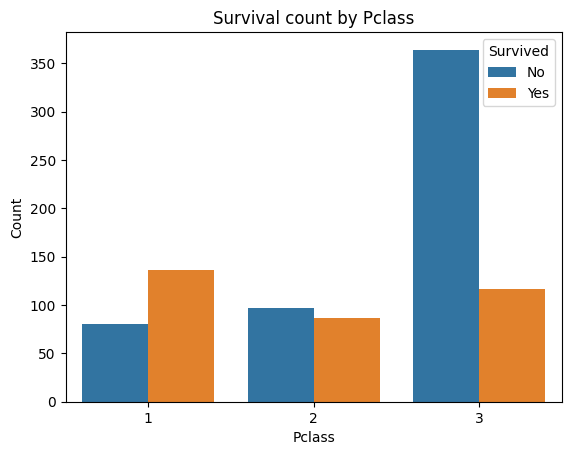

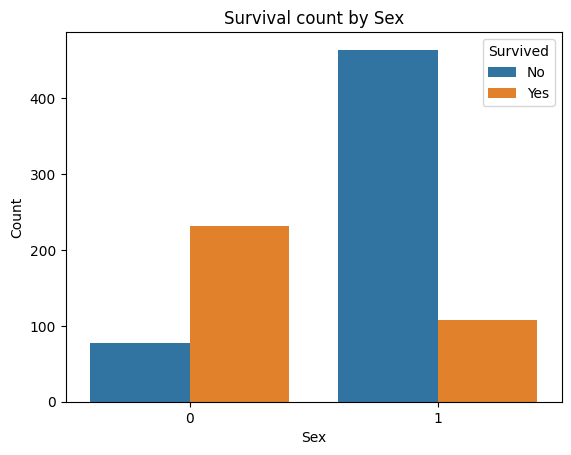

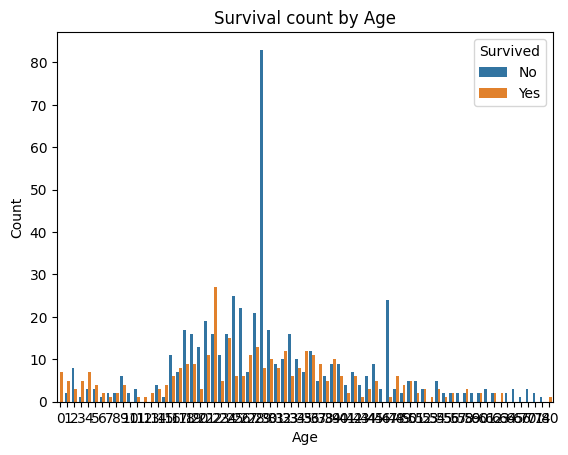

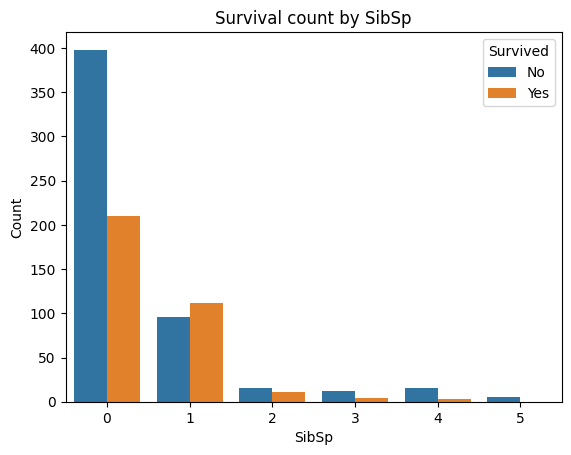

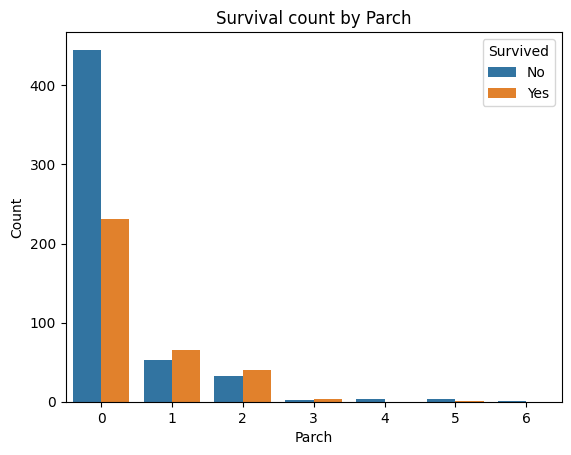

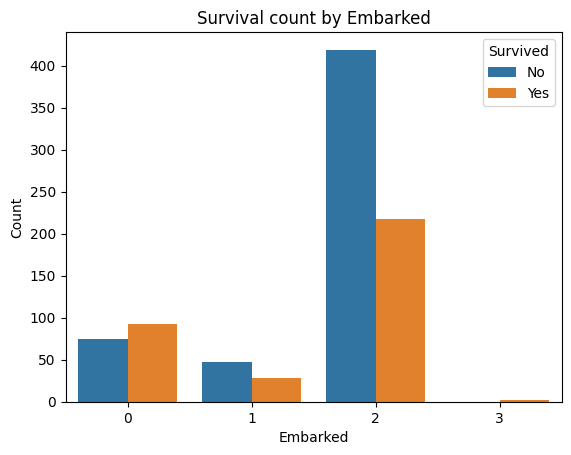

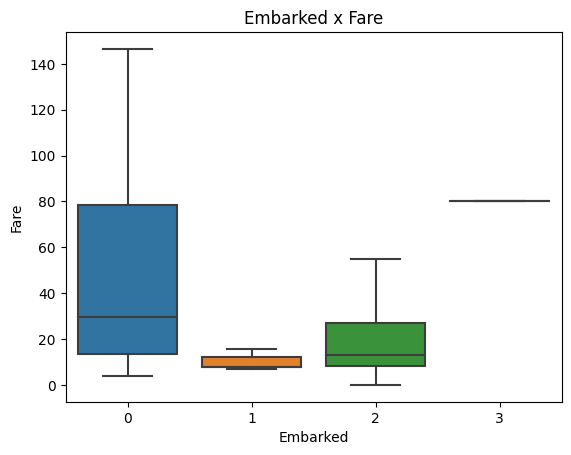

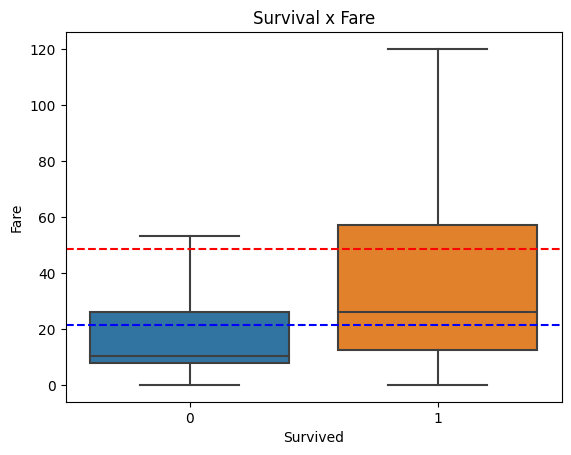

In [128]:
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']

for column in columns:
    sns.countplot(x=column, hue='Survived', data=train)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Survival count by {column}')
    plt.legend(title='Survived', labels=['No', 'Yes'])

    plt.show()


sns.boxplot(x='Embarked', y='Fare', data=train, showfliers=False)

plt.xlabel('Embarked')
plt.ylabel('Fare')
plt.title('Embarked x Fare')
plt.show()


mean_survived = train[train['Survived']==1]['Fare'].mean()
mean_not_survived = train[train['Survived']==0]['Fare'].mean()

sns.boxplot(x='Survived', y='Fare', data=train, showfliers=False)

plt.axhline(mean_survived, color='r', linestyle = '--', label = 'Mean Fare (Survived)')
plt.axhline(mean_not_survived, color = 'b', linestyle = '--', label = 'Mean Fare (Not Survived)')
plt.xlabel('Survived')
plt.ylabel('Fare')
plt.title('Survival x Fare')
plt.show()


<Axes: >

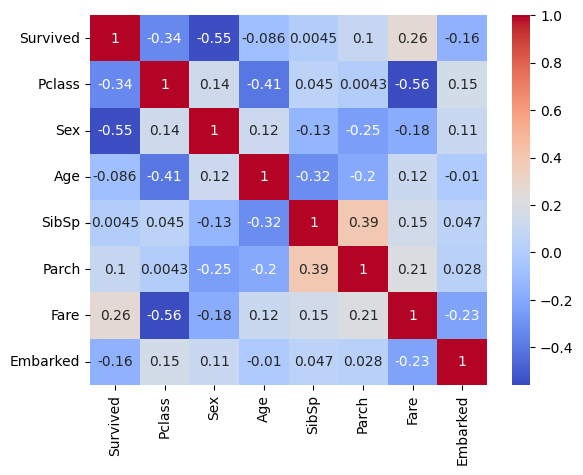

In [129]:
correlation_columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
correlation_matrix = train[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm')

# The analysis suggests that the survival is highly correlated to Fare, Sex and PClass values. 
# The mean fare of those who survived was around 50. The mean fare of those who died is around 20
# Around 75% of womens survived, around 19% of men survived
# Pclass that survived the most was 1 


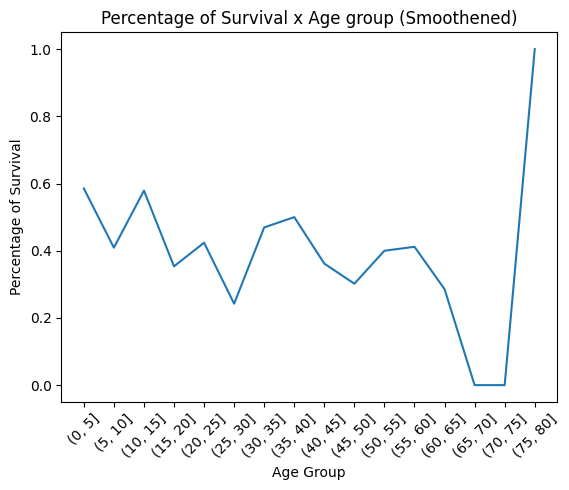

In [130]:
train['AgeGroup'] = pd.cut(train['Age'], bins=range(0,81,5))
age_group_survival=train.groupby('AgeGroup')['Survived'].mean()
rolling_mean = age_group_survival.rolling(window=5, center=True).mean()


plt.plot(age_group_survival.index.astype(str), age_group_survival.values)
plt.xlabel('Age Group')
plt.ylabel('Percentage of Survival')
plt.title('Percentage of Survival x Age group (Smoothened)')
plt.xticks(rotation=45)
plt.show()

# This analysis indicates that age groups that survived the most are between 0 an 5, 10 and 15 and 75 and 80. The group that least survived was 25 to 30 and 60 to 65

In [131]:
sex_survival = train.groupby('Sex')['Survived'].mean()

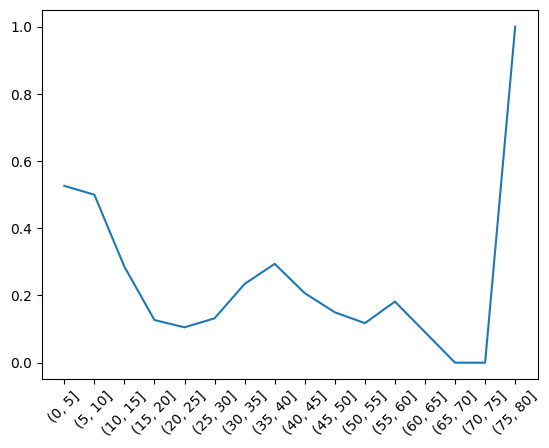

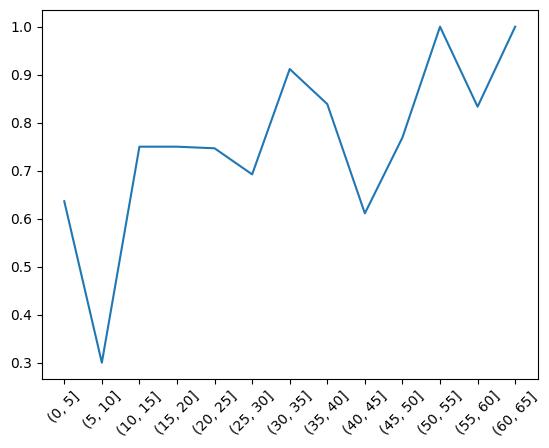

In [132]:
men_age_group_survival = train[train['Sex']==1].groupby('AgeGroup')['Survived'].mean()
women_age_group_survival = train[train['Sex']==0].groupby('AgeGroup')['Survived'].mean()
plt.plot(men_age_group_survival.index.astype(str), men_age_group_survival.values)
plt.xticks(rotation=45)
plt.show()

plt.plot(women_age_group_survival.index.astype(str), women_age_group_survival.values)
plt.xticks(rotation=45)
plt.show()

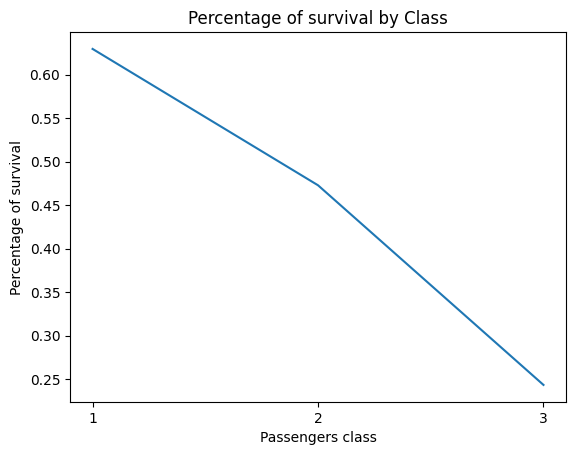

In [133]:
pclass_group_survival = train.groupby('Pclass')['Survived'].mean()

plt.plot(pclass_group_survival.index, pclass_group_survival.values)
plt.xlabel('Passengers class')
plt.ylabel('Percentage of survival')
plt.title('Percentage of survival by Class')
plt.xticks(pclass_group_survival.index, [1, 2, 3])
plt.show()

In [153]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

X = train.drop(['Survived', 'Name', 'Cabin', 'Ticket', 'AgeGroup'], axis=1)
y = train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.4)

rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=0)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

np.mean(y_val == y_pred)

0.7988668555240793

: 

In [146]:
temp = pd.Series(y_pred, index = test['PassengerId'], name = 'Survived')

temp.to_csv("Submissao_titanic_kaggle.csv", header=True)